# Preprocessing Plan

Based on exploratoty analysis, the following preprocessing steps are required:
1. Combine symptom data with diagnosis labels (assuming row-wise alignment)
2. Standardise disease labels to reduce duplicates and inconsistencies
3. Handle rare disease cases with low sample counts
4. Clean and standardise binary symptom counts
5. Encode categorical variables
6. convert Body_Temperature from string to numeric float
7. Standardise Duration to a single unit (days)
8. Prepare final feature matrix and target vector for modeling


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


## Load Data

In [2]:
symptoms_df = pd.read_csv("../data/raw/Animal Symptoms.csv")
diagnosis_df = pd.read_csv("../data/raw/Disease Prediction.csv")

## Combine Datasets

In [3]:
df = symptoms_df.copy()
df["Disease_Prediction"]= diagnosis_df["Disease_Prediction"]

In [4]:
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection


## Clean Labels

In [5]:
df["Disease_Prediction"].value_counts().head(20)

Disease_Prediction
Bovine Tuberculosis               15
Bovine Respiratory Disease        14
Equine Influenza                  13
Canine Parvovirus                 12
Caprine Arthritis Encephalitis    12
Canine Distemper                  10
Scrapie                           10
Swine Influenza                   10
Parvovirus                         9
Gastroenteritis                    9
Kennel Cough                       9
Equine Infectious Anemia           9
Feline Infectious Peritonitis      8
Feline Calicivirus                 8
Feline Herpesvirus                 7
Pneumonia                          7
Actinobacillus Pleuropneumonia     7
Equine Herpesvirus                 7
Foot-and-Mouth Disease             6
Rabbit Hemorrhagic Disease         6
Name: count, dtype: int64

In [6]:
df["Disease_Prediction"].nunique()

139

139 unique diseases pre processing

In [7]:
# create cleaned disease column

df["Disease_clean"] = (
    df["Disease_Prediction"]
    .str.lower()
    .str.strip()
)


In [8]:
# fix formatting inconsistencies
df["Disease_clean"] = (
    df["Disease_clean"]
    .str.replace("-", " ", regex=False)
    .str.replace("'", "", regex=False)
)


In [9]:
# create mapping dictionary for duplicates

disease_map = {
    # Parvovirus group
    "canine parvovirus": "parvovirus",
    "feline panleukopenia": "parvovirus",
    "feline panleukopenia virus": "parvovirus",

    # Upper respiratory group
    "feline upper respiratory infection": "upper respiratory infection",
    "respiratory infection": "upper respiratory infection",
    "feline respiratory infection": "upper respiratory infection",

    # Distemper
    "canine distemper": "distemper",

    # Leukemia
    "feline leukemia virus": "feline leukemia",

    # Bluetongue
    "blue tongue": "bluetongue",
    "blue tongue virus": "bluetongue",
    "blue tongue disease": "bluetongue",

    # Foot and mouth
    "foot and mouth disease": "foot and mouth disease",
}


In [10]:
# apply mapping to disease_clean
df["Disease_clean"] = df["Disease_clean"].replace(disease_map)

In [11]:
#check ouput
df["Disease_clean"].value_counts().head(20)

Disease_clean
parvovirus                        25
bovine tuberculosis               15
bovine respiratory disease        14
equine influenza                  13
upper respiratory infection       12
distemper                         12
caprine arthritis encephalitis    12
foot and mouth disease            10
scrapie                           10
swine influenza                   10
gastroenteritis                    9
kennel cough                       9
equine infectious anemia           9
bluetongue                         9
feline leukemia                    8
feline infectious peritonitis      8
feline calicivirus                 8
feline herpesvirus                 7
pneumonia                          7
actinobacillus pleuropneumonia     7
Name: count, dtype: int64

In [12]:
df["Disease_clean"].nunique()

127

138 unique diseases after cleaning

Handle rare diseases <3 cases for sensability

In [13]:
disease_counts = df["Disease_clean"].value_counts()


rare_diseases = disease_counts[disease_counts <3]

In [14]:
len(rare_diseases)

79

In [15]:
rare_diseases.head(20)

Disease_clean
fungal infection                       2
lyme disease                           2
intestinal parasites                   2
ringworm                               2
salmonellosis                          2
equine leptospirosis                   2
feline viral rhinotracheitis           2
equine encephalitis                    2
equine osteoarthritis                  2
feline respiratory disease complex     2
feline rhinotracheitis                 2
swine dysentery                        2
equine metabolic syndrome              2
caseous lymphadenitis                  2
leptospirosis                          2
chlamydia in sheep                     2
porcine respiratory disease complex    2
contagious ecthyma                     2
bluetongue virus                       2
caprine viral arthritis                2
Name: count, dtype: int64

Species specifics on diagnoses may be inflating counts.  

In [16]:
# remove species

species_terms = [
    "canine",
    "feline",
    "equine",
    "bovine",
    "caprine",
    "porcine",
    "rabbit",
    "swine",
]


In [17]:
def remove_species_prefix(label):
    if pd.isna(label):
        return label

    for species in species_terms:
        pattern = rf"^{species}\s+"
        label = re.sub(pattern, "", label)

    return label.strip()

In [18]:
df["Disease_nospecies"] = df["Disease_clean"].apply(remove_species_prefix)


In [19]:
#compare outputs
print("Before:", df["Disease_clean"].nunique())
print("After removing species:", df["Disease_nospecies"].nunique())


Before: 127
After removing species: 102


In [20]:
df["Disease_nospecies"].value_counts().head(15)


Disease_nospecies
parvovirus                     25
influenza                      25
respiratory disease            18
tuberculosis                   16
herpesvirus                    14
upper respiratory infection    12
distemper                      12
arthritis encephalitis         12
foot and mouth disease         10
scrapie                        10
gastroenteritis                 9
kennel cough                    9
johnes disease                  9
infectious anemia               9
pneumonia                       9
Name: count, dtype: int64

In [21]:
df.loc[
    df["Disease_clean"] != df["Disease_nospecies"],
    ["Disease_clean", "Disease_nospecies"]
].drop_duplicates().head(20)


,Disease_clean,Disease_nospecies
5,equine influenza,influenza
14,bovine respiratory disease,respiratory disease
26,feline herpesvirus,herpesvirus
27,equine rhinopneumonitis,rhinopneumonitis
29,feline leukemia,leukemia
32,feline infectious peritonitis,infectious peritonitis
33,equine viral arteritis,viral arteritis
37,equine piroplasmosis,piroplasmosis
43,equine arthritis,arthritis
47,equine infectious anemia,infectious anemia


Disease labels were further consolidated by mapping pathogen-specific and syndrome-level terms to broader clinical categories.  
This reflects symptom-based diagnostic reasoning and reduces class fragmentation in the target variable.


In [22]:
#create new target column
df["Disease_final"] = df["Disease_nospecies"]


In [23]:
# Normalise simple synonyms
synonym_map = {
    "flu": "influenza",
}

df["Disease_final"] = df["Disease_final"].replace(synonym_map)


In [24]:
# group viral respiratoy diseases
viral_respiratory = [
    "herpesvirus",
    "calicivirus",
    "coronavirus",
    "rhinotracheitis",
    "respiratory syncytial virus",
    "viral rhinotracheitis",
    "feline coronavirus",
]
df.loc[
    df["Disease_final"].isin(viral_respiratory),
    "Disease_final"
] = "viral respiratory disease"


In [25]:
# group non-viral respiratory syndromes

respiratory = [
    "respiratory disease",
    "upper respiratory infection",
    "kennel cough",
    "snuffles",
    "chronic bronchitis",
    "pneumonia",
    "respiratory infection",
    "respiratory disease complex",
    "actinobacillus pleuropneumonia",
    "pleuropneumonia",
    "pasteurellosis",
    "asthma",
]
df.loc[
    df["Disease_final"].isin(respiratory),
    "Disease_final"
] = "respiratory disease"

In [26]:
gastrointestinal = [
    "gastroenteritis",
    "enteritis",
    "gastrointestinal infection",
    "gastrointestinal stasis",
    "inflammatory bowel disease",
    "epidemic diarrhea",
    "viral diarrhea",
    "coccidiosis",
    "pancreatitis",
]

df.loc[
    df["Disease_final"].isin(gastrointestinal),
    "Disease_final"
] = "gastrointestinal disease"

In [27]:
systemic_viral = [
    "arthritis encephalitis",
    "infectious anemia",
    "infectious peritonitis",
    "leukemia virus",
    "panleukopenia",
    "viral hemorrhagic disease",
    "hemorrhagic disease",
    "myxomatosis",
    "west nile virus",
    "bluetongue",
]

df.loc[
    df["Disease_final"].isin(systemic_viral),
    "Disease_final"
] = "systemic viral disease"



In [28]:
core_map = {
    "parvovirus": "parvovirus",
    "influenza": "influenza",
    "tuberculosis": "tuberculosis",
    "distemper": "distemper",
    "arthritis": "arthritis",
    "mastitis": "mastitis",
    "scrapie": "scrapie",
    "foot and mouth disease": "foot and mouth disease",
}


In [29]:
df["Disease_final"] = df["Disease_final"].replace(core_map)


In [30]:
allowed_classes = [
    "respiratory disease",
    "viral respiratory disease",
    "gastrointestinal disease",
    "systemic viral disease",
    "parvovirus",
    "influenza",
    "tuberculosis",
    "distemper",
    "arthritis",
    "mastitis",
    "scrapie",
    "foot and mouth disease",
]

df.loc[
    ~df["Disease_final"].isin(allowed_classes),
    "Disease_final"
] = "other"


In [31]:
df["Disease_final"].value_counts()


Disease_final
other                        117
respiratory disease           77
systemic viral disease        63
viral respiratory disease     32
gastrointestinal disease      28
influenza                     28
parvovirus                    25
tuberculosis                  16
distemper                     12
foot and mouth disease        10
scrapie                       10
mastitis                       7
arthritis                      6
Name: count, dtype: int64

In [32]:
df["Disease_final"].nunique()


13

Inspection of the "other"category is needed to ensure nothing is being missed

In [33]:
df.loc[df["Disease_final"] == "other", "Disease_nospecies"].value_counts().head(20)


Disease_nospecies
johnes disease                 9
leptospirosis                  9
leukemia                       8
laminitis                      5
lyme disease                   3
rhinopneumonitis               3
hepatitis                      3
syphilis                       3
protozoal myeloencephalitis    3
encephalomyelitis              3
erysipelas                     3
fever                          3
fungal infection               2
intestinal parasites           2
ringworm                       2
heartworm disease              2
salmonellosis                  2
encephalitis                   2
osteoarthritis                 2
dysentery                      2
Name: count, dtype: int64

After iterative consolidation, remaining labels in the 'other' category were low-frequency and heterogeneous, and no further clinically meaningful grouping was justified.

Symptom feature cleaning

- end goal - binary symptoms encoded as 0/1

In [34]:
symptom_columns = [
    "Appetite_Loss",
    "Vomiting",
    "Diarrhea",
    "Coughing",
    "Labored_Breathing",
    "Lameness",
    "Skin_Lesions",
    "Nasal_Discharge",
    "Eye_Discharge",
]


In [35]:
for col in symptom_columns:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))



Appetite_Loss
Appetite_Loss
Yes    381
No      50
Name: count, dtype: int64

Vomiting
Vomiting
Yes    247
No     184
Name: count, dtype: int64

Diarrhea
Diarrhea
No     219
Yes    212
Name: count, dtype: int64

Coughing
Coughing
Yes    288
No     143
Name: count, dtype: int64

Labored_Breathing
Labored_Breathing
Yes    236
No     195
Name: count, dtype: int64

Lameness
Lameness
Yes    246
No     185
Name: count, dtype: int64

Skin_Lesions
Skin_Lesions
Yes    239
No     192
Name: count, dtype: int64

Nasal_Discharge
Nasal_Discharge
No     224
Yes    207
Name: count, dtype: int64

Eye_Discharge
Eye_Discharge
Yes    225
No     206
Name: count, dtype: int64


In [36]:
binary_map = {
    "yes": 1,
    "no": 0,

}


In [37]:
binary_symptoms = [
    "Appetite_Loss",
    "Vomiting",
    "Diarrhea",
    "Coughing",
    "Labored_Breathing",
    "Lameness",
    "Skin_Lesions",
    "Nasal_Discharge",
    "Eye_Discharge",
]

for col in binary_symptoms:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .map(binary_map)
    )


In [38]:
df[binary_symptoms] = df[binary_symptoms].fillna(0)


In [39]:
for col in binary_symptoms:
    print(col, df[col].unique())


Appetite_Loss [1 0]
Vomiting [1 0]
Diarrhea [0 1]
Coughing [0 1]
Labored_Breathing [0 1]
Lameness [0 1]
Skin_Lesions [0 1]
Nasal_Discharge [0 1]
Eye_Discharge [0 1]


In [40]:
symptom_text_cols = ["Symptom_1", "Symptom_2", "Symptom_3", "Symptom_4"]


In [41]:
df[symptom_text_cols] = (
    df[symptom_text_cols]
    .apply(lambda col: col.astype(str).str.lower().str.strip())
)


In [42]:
symptom_synonyms = {
    "loss of appetite": "appetite loss",
    "reduced appetite": "appetite loss",
    "decreased milk yield": "reduced milk production",
    "swollen legs": "swollen joints",
}


In [43]:
for col in symptom_text_cols:
    df[col] = df[col].replace(symptom_synonyms)


In [44]:
core_symptoms = [
    "fever",
    "lethargy",
    "appetite loss",
    "vomiting",
    "diarrhea",
    "coughing",
    "labored breathing",
    "nasal discharge",
    "eye discharge",
    "lameness",
    "skin lesions",
    "weight loss",
    "swollen joints",
    "dehydration",
]


In [45]:
for symptom in core_symptoms:
    col_name = f"symptom_{symptom.replace(' ', '_')}"
    df[col_name] = df[symptom_text_cols].eq(symptom).any(axis=1).astype(int)


In [46]:
df = df.drop(columns=symptom_text_cols)


Multiple symptom fields were consolidated into binary symptom indicators, encoding the presence of each clinical sign regardless of original column position.


In [47]:
[c for c in df.columns if c.startswith("symptom_")]


['symptom_fever',
 'symptom_lethargy',
 'symptom_appetite_loss',
 'symptom_vomiting',
 'symptom_diarrhea',
 'symptom_coughing',
 'symptom_labored_breathing',
 'symptom_nasal_discharge',
 'symptom_eye_discharge',
 'symptom_lameness',
 'symptom_skin_lesions',
 'symptom_weight_loss',
 'symptom_swollen_joints',
 'symptom_dehydration']

In [48]:
df[[c for c in df.columns if c.startswith("symptom_")]].describe()


,symptom_fever,symptom_lethargy,symptom_appetite_loss,symptom_vomiting,symptom_diarrhea,symptom_coughing,symptom_labored_breathing,symptom_nasal_discharge,symptom_eye_discharge,symptom_lameness,symptom_skin_lesions,symptom_weight_loss,symptom_swollen_joints,symptom_dehydration
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.691415,0.658933,0.791183,0.245940,0.174014,0.433875,0.069606,0.278422,0.058005,0.136891,0.020882,0.081206,0.148492,0.044084
std,0.462446,0.474619,0.406936,0.431143,0.379562,0.496184,0.254777,0.448743,0.234024,0.344132,0.143154,0.273469,0.356000,0.205519
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
df.sample(5)[
    [
        "symptom_fever",
        "symptom_lethargy",
        "symptom_appetite_loss",
        "symptom_vomiting",
        "symptom_diarrhea",
        "symptom_coughing",
        "symptom_labored_breathing",
        "symptom_nasal_discharge",
        "symptom_eye_discharge",
    ]
]


,symptom_fever,symptom_lethargy,symptom_appetite_loss,symptom_vomiting,symptom_diarrhea,symptom_coughing,symptom_labored_breathing,symptom_nasal_discharge,symptom_eye_discharge
213,1,1,1,0,0,1,0,0,0
140,1,0,0,0,0,1,1,1,0
120,0,1,1,0,1,0,0,0,0
58,0,1,1,1,0,0,0,0,0
85,0,0,1,0,0,0,0,0,0


In [50]:
df[[c for c in df.columns if c.startswith("symptom_")]].sum().sort_values(ascending=False)


symptom_appetite_loss        341
symptom_fever                298
symptom_lethargy             284
symptom_coughing             187
symptom_nasal_discharge      120
symptom_vomiting             106
symptom_diarrhea              75
symptom_swollen_joints        64
symptom_lameness              59
symptom_weight_loss           35
symptom_labored_breathing     30
symptom_eye_discharge         25
symptom_dehydration           19
symptom_skin_lesions           9
dtype: int64

In [51]:
symptom_text_cols = ["Symptom_1", "Symptom_2", "Symptom_3", "Symptom_4"]
set(symptom_text_cols).intersection(df.columns)


set()

In [52]:
df[[c for c in df.columns if c.startswith("symptom_")]].sum(axis=1).describe()


count    431.000000
mean       3.832947
std        0.385710
min        2.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        4.000000
dtype: float64

Free-text symptom fields were successfully converted into binary symptom indicators.
Spot checks confirmed accurate preservation of symptom presence across rows.


In [53]:
# convert duration from weeks or days into days

In [54]:
df["Duration"].value_counts().head(10)


Duration
5 days     133
4 days      87
6 days      83
3 days      47
7 days      30
8 days      14
2 days      11
10 days     10
1 week       6
2 weeks      5
Name: count, dtype: int64

In [55]:


duration = df["Duration"].str.lower()

# Extract numeric value
df["Duration_value"] = duration.str.extract(r"(\d+)").astype(float)

# Extract unit
df["Duration_unit"] = duration.str.extract(r"(day|days|week|weeks)")


In [56]:
df["Duration_days"] = np.where(
    df["Duration_unit"].isin(["week", "weeks"]),
    df["Duration_value"] * 7,
    df["Duration_value"]
)


In [57]:
df[["Duration", "Duration_days"]].isna().sum()


Duration         0
Duration_days    0
dtype: int64

In [58]:
df = df.drop(columns=["Duration", "Duration_value", "Duration_unit"])


In [59]:
df["Duration_days"].describe()


count    431.000000
mean       5.234339
std        1.849784
min        2.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       14.000000
Name: Duration_days, dtype: float64

<Axes: >

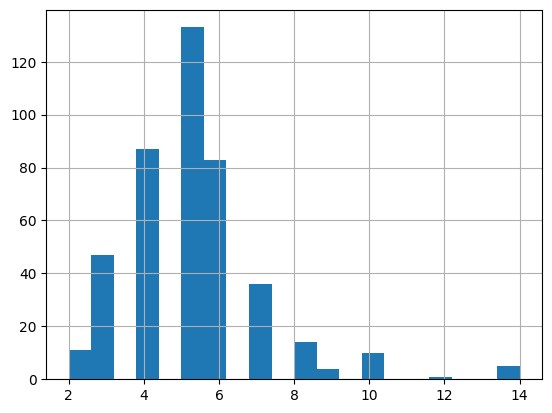

In [60]:
df["Duration_days"].hist(bins=20)


In [61]:
# handle body temp column

In [62]:
df["Body_Temperature"].value_counts().head()


Body_Temperature
39.2°C    57
39.4°C    54
39.3°C    50
39.5°C    46
39.0°C    41
Name: count, dtype: int64

In [63]:
# strip units and convert to float

df["Body_Temperature_C"] = (
    df["Body_Temperature"]
    .str.replace("°C", "", regex=False)
    .astype(float)
)


In [64]:
df[["Body_Temperature", "Body_Temperature_C"]].isna().sum()


Body_Temperature      0
Body_Temperature_C    0
dtype: int64

In [65]:
# drop original column to remove confusion
df = df.drop(columns=["Body_Temperature"])


In [66]:
df["Body_Temperature_C"].describe()


count    431.000000
mean      39.302088
std        0.320422
min       38.400000
25%       39.100000
50%       39.300000
75%       39.500000
max       40.200000
Name: Body_Temperature_C, dtype: float64

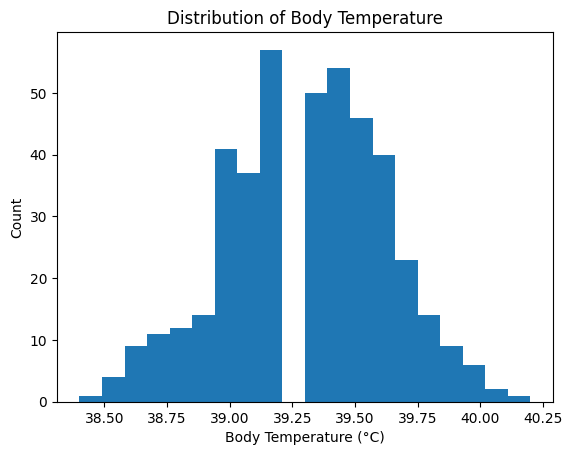

In [67]:
plt.hist(df["Body_Temperature_C"], bins=20)
plt.xlabel("Body Temperature (°C)")
plt.ylabel("Count")
plt.title("Distribution of Body Temperature")
plt.show()


In [68]:
# save processed data as csv

import os
os.makedirs("data/processed", exist_ok=True)



In [69]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Animal_Type                431 non-null    str    
 1   Breed                      431 non-null    str    
 2   Age                        431 non-null    int64  
 3   Gender                     431 non-null    str    
 4   Weight                     431 non-null    float64
 5   Appetite_Loss              431 non-null    int64  
 6   Vomiting                   431 non-null    int64  
 7   Diarrhea                   431 non-null    int64  
 8   Coughing                   431 non-null    int64  
 9   Labored_Breathing          431 non-null    int64  
 10  Lameness                   431 non-null    int64  
 11  Skin_Lesions               431 non-null    int64  
 12  Nasal_Discharge            431 non-null    int64  
 13  Eye_Discharge              431 non-null    int64  
 14  Heart

In [70]:
df.to_csv(
    "data/processed/vet_disease_processed.csv",
    index=False
)


In [71]:
df_check = pd.read_csv("data/processed/vet_disease_processed.csv")
df_check.head()


,Animal_Type,Breed,Age,Gender,Weight,Appetite_Loss,Vomiting,Diarrhea,Coughing,Labored_Breathing,...,symptom_labored_breathing,symptom_nasal_discharge,symptom_eye_discharge,symptom_lameness,symptom_skin_lesions,symptom_weight_loss,symptom_swollen_joints,symptom_dehydration,Duration_days,Body_Temperature_C
0,Dog,Labrador,4,Male,25.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,3.0,39.5
1,Cat,Siamese,2,Female,4.5,0,0,0,1,0,...,0,1,1,0,0,0,0,0,7.0,38.9
2,Cow,Holstein,3,Female,600.0,1,0,0,1,1,...,1,1,0,0,0,0,0,0,5.0,40.1
3,Dog,Beagle,1,Male,10.0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,2.0,39.2
4,Cat,Persian,5,Male,3.8,1,0,0,0,0,...,0,0,0,0,1,0,0,0,14.0,38.7


In [72]:
df_check.equals(df)


True